# 03 - Data Visualization & Insights (WineQT)

Histogramas, boxplots, scatter plots e heatmaps + insights de qualidade.



In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from huggingface_hub import hf_hub_download

# Carrega variáveis do .env
from dotenv import load_dotenv
load_dotenv(override=True)

def get_env_strip_quotes(key: str) -> str:
    val = os.getenv(key, '')
    return val.strip('\'"')

HF_TOKEN = get_env_strip_quotes('HF_TOKEN')
HF_PROCESSED_REPO = os.getenv('HF_PROCESSED_REPO', 'henriquebap/wine-ml-processed')

# Carrega df_capped do HF Hub (fallback local)
try:
    df_path = hf_hub_download(
        repo_id=HF_PROCESSED_REPO,
        filename='processed/full.csv',
        repo_type='dataset',
        token=HF_TOKEN if HF_TOKEN else None
    )
    df = pd.read_csv(df_path)
    print('✅ Dados carregados do HF Hub:', HF_PROCESSED_REPO)
except Exception as e:
    print('⚠️ Fallback para dados locais:', e)
    proc = Path.cwd().parent / 'data' / 'processed' / 'df_capped.csv'
    if proc.exists():
        df = pd.read_csv(proc)
    else:
        from src.data_ingestion import load_wine_dataframe
        HF_REPO = os.getenv("HF_DATASET_REPO", "henriquebap/wine-ml-dataset")
        FILENAME = os.getenv("HF_DATASET_FILENAME", "WineQT.csv")
        df = load_wine_dataframe(repo_id=HF_REPO, filename=FILENAME)

# target
if 'quality_class' not in df.columns and 'quality' in df.columns:
    df['quality_class'] = df['quality'].apply(lambda x: 'Baixa (3-4)' if x <= 4 else 'Média (5-6)' if x <= 6 else 'Alta (7-8)')
order = ['Baixa (3-4)', 'Média (5-6)', 'Alta (7-8)']
palette_classes = {'Baixa (3-4)': '#d62728', 'Média (5-6)': '#1f77b4', 'Alta (7-8)': '#2ca02c'}

# selected features (fallback para todas as numéricas)
selected_features = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'quality']

print('Usando', len(selected_features), 'features.')
df[selected_features + ['quality_class']].head()


✅ Dados carregados do HF Hub: henriquebap/wine-ml-processed
Usando 11 features.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_class
0,2.128232,0.70,0.00,1.064711,0.073250,2.484907,3.555348,0.9978,3.51,0.444686,9.4,Média (5-6)
1,2.174752,0.88,0.00,1.280934,0.093490,3.258097,4.219508,0.9968,3.20,0.518794,9.8,Média (5-6)
2,2.174752,0.76,0.04,1.193922,0.088011,2.772589,4.007333,0.9970,3.26,0.500775,9.8,Média (5-6)
3,2.501436,0.28,0.56,1.064711,0.072321,2.890372,4.110874,0.9980,3.16,0.457425,9.8,Média (5-6)
4,2.128232,0.66,0.00,1.029619,0.072321,2.639057,3.713572,0.9978,3.51,0.444686,9.4,Média (5-6)


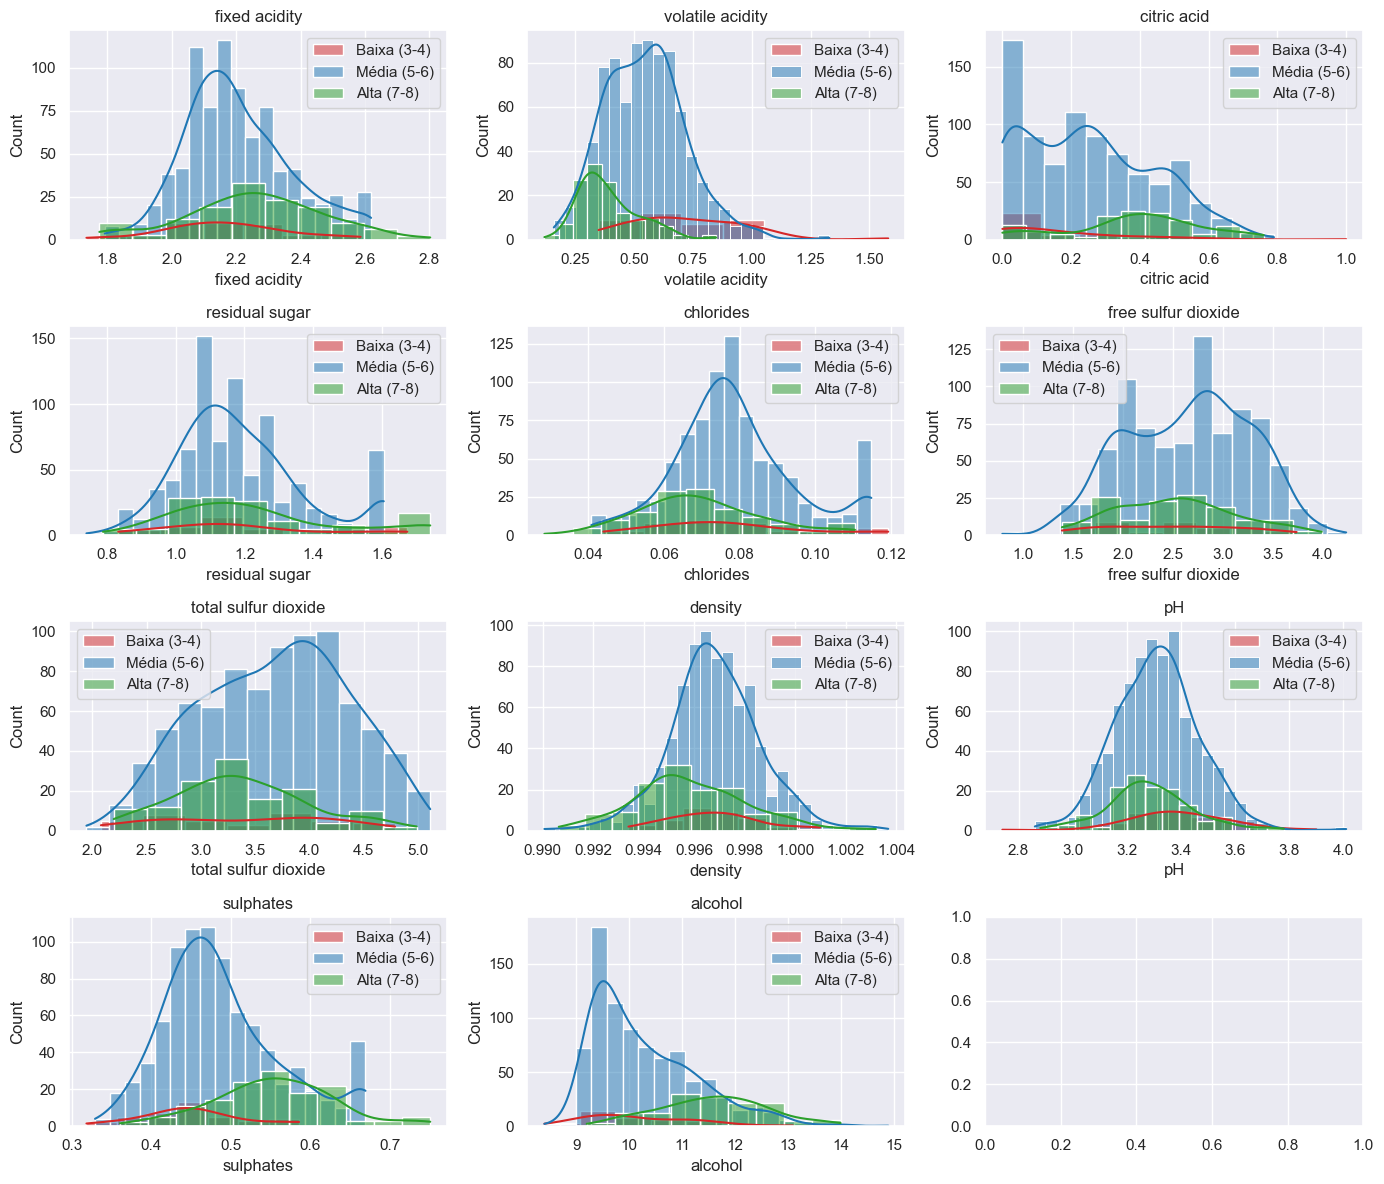

In [2]:
sns.set_theme()
# Histograms por classe
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    for cls in order:
        sns.histplot(df[df['quality_class']==cls][col], kde=True, ax=axes[i], 
                     label=cls, color=palette_classes[cls], alpha=0.5)
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()


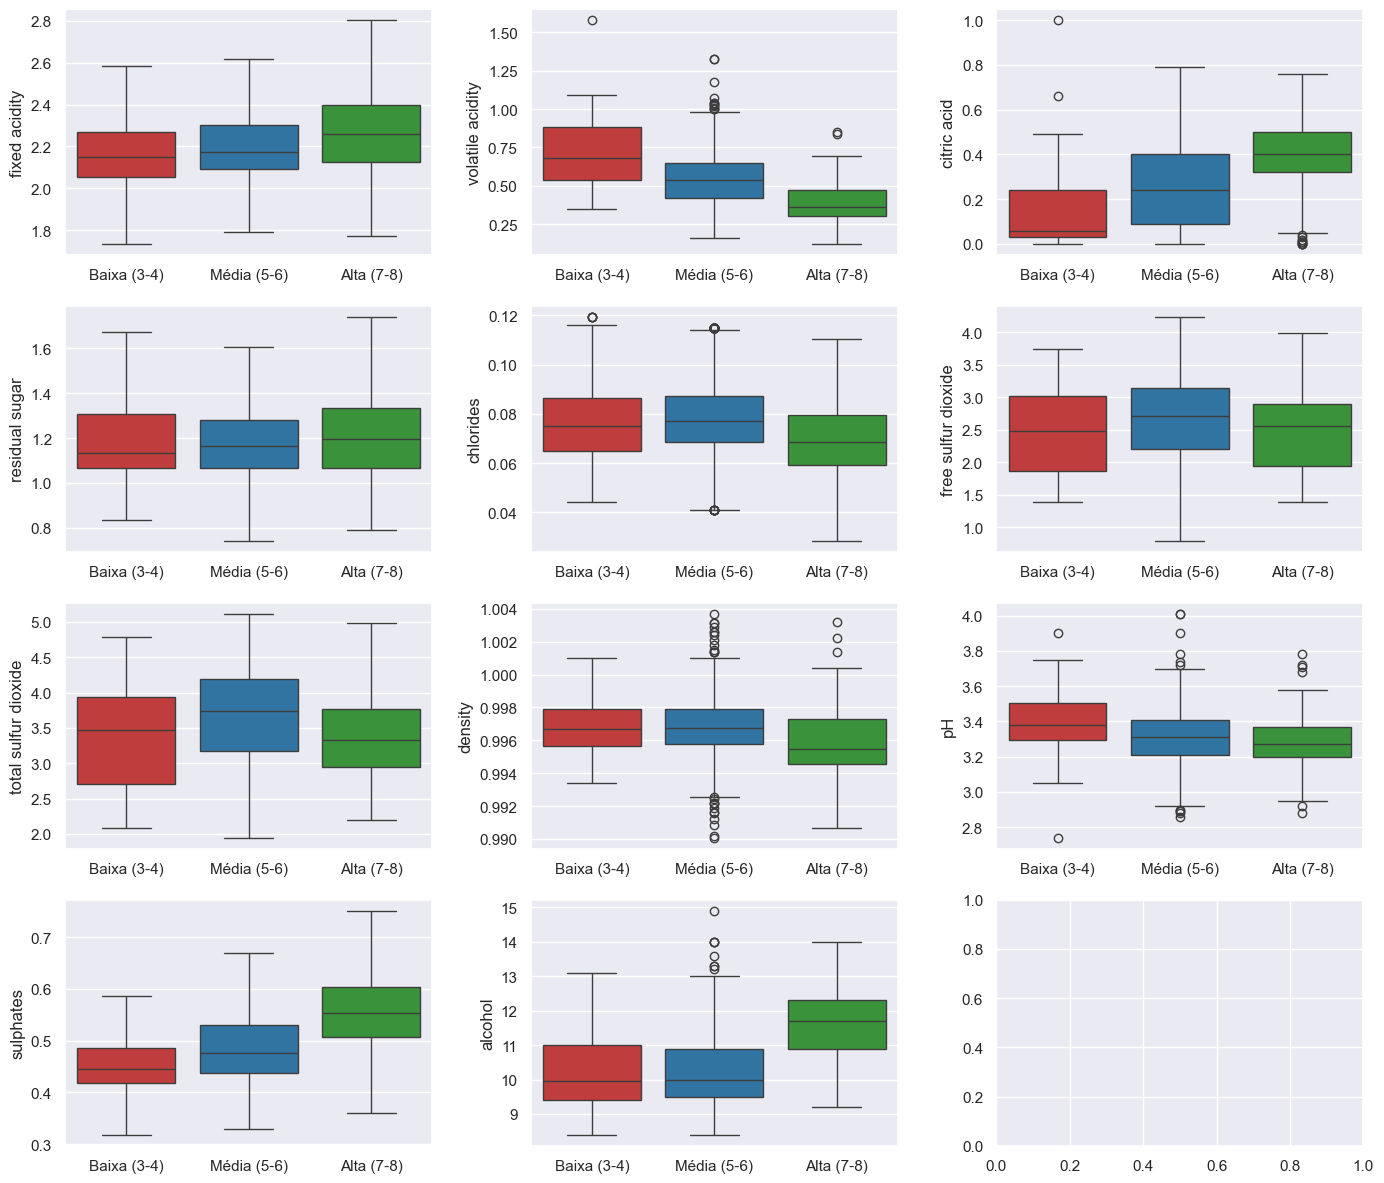

In [6]:
# Boxplots por quality_class
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    sns.boxplot(
        data=df,
        x='quality_class',
        y=col,
        hue='quality_class',
        order=order,
        palette=palette_classes,
        ax=axes[i],
        legend=False
    )
    axes[i].set_xlabel('')
    axes[i].legend_.remove() if axes[i].legend_ else None  # Remove legend if present
plt.tight_layout()
plt.show()


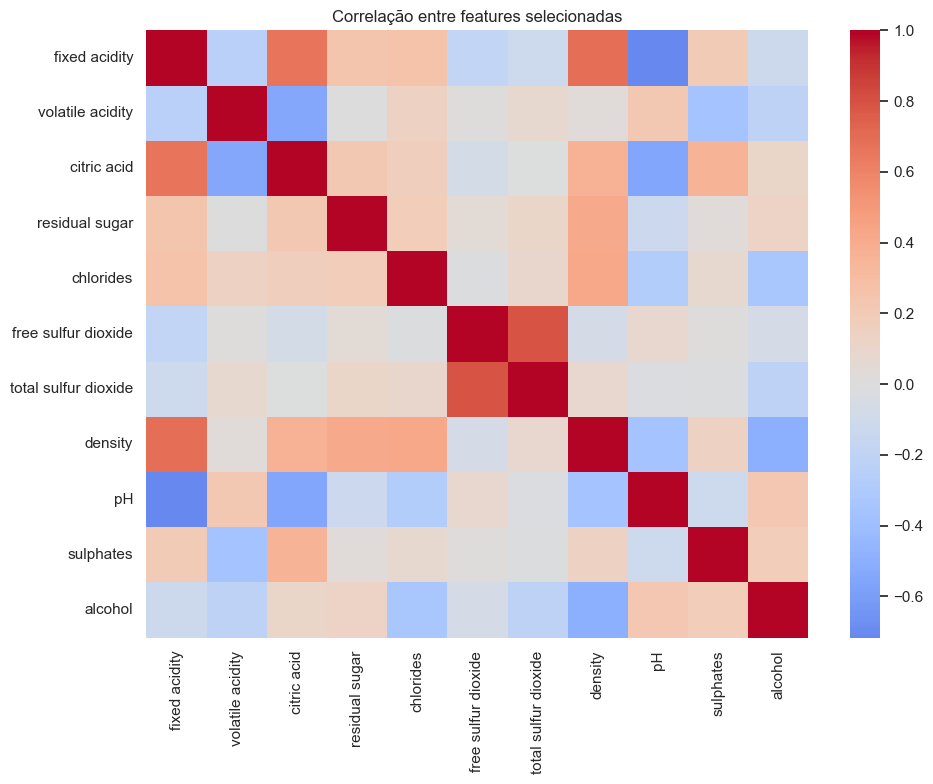

Figuras exportadas para: reports/viz


In [5]:
# Correlation heatmap (selected features)
plt.figure(figsize=(10,8))
corr_df = df[selected_features].corr()
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Correlação entre features selecionadas')
plt.tight_layout()
plt.show()

# Export figuras
from pathlib import Path
out_dir = Path('reports/viz'); out_dir.mkdir(parents=True, exist_ok=True)
print('Figuras exportadas para:', out_dir)
